In [4]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive


# ✅ 挂载 Google Drive
drive.mount('/content/drive')
# ========== 📂 CONFIG ==========


# ========== 📂 CONFIG ==========
intervals = [(201, 300), (301, 400), (401, 600)]
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
OUTPUT_CSV = os.path.join(BASE_PATH, "output/stat_logits/positive_sigmoid_score_by_pair.csv")

# ✅ Sigmoid 映射函数
def sigmoid_scaled(x, center=0.9, scale=20):
    return 1 / (1 + np.exp(-scale * (x - center)))

def avg_sigmoid_score_scaled(probs, center=0.9, scale=20):
    if len(probs) < 2:
        return 0.0
    probs = np.array(probs)
    return np.mean(sigmoid_scaled(probs, center=center, scale=scale))



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
intervals = [(201, 300)]

In [6]:

# ========== 📊 COLLECTED RESULTS ==========
step_stats = []
start_index=201
end_index=300
# ========== 🔁 遍历每个区间 ==========
range_tag = f"{start_index}-{end_index}"
print(f"🔍 Processing range: {range_tag}")

# 路径
INFERENCE_PATH = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")
POSITIVE_PAIR_OUTPUT_PATH = os.path.join(BASE_PATH, f"output/consis_cases/positive_pairs_deepseek7b-math-{range_tag}.json")

# 加载数据
with open(INFERENCE_PATH, 'r') as f:
    inference_data = json.load(f)
with open(POSITIVE_PAIR_OUTPUT_PATH, 'r') as f:
    positive_data = json.load(f)


🔍 Processing range: 201-300


In [7]:
positive_data

{'q_201': {'positive_pairs': [['sampling1', 'sampling2']]},
 'q_203': {'positive_pairs': [['sampling0', 'sampling1'],
   ['sampling0', 'sampling2'],
   ['sampling1', 'sampling2']]},
 'q_204': {'positive_pairs': [['sampling0', 'sampling1'],
   ['sampling0', 'sampling2'],
   ['sampling1', 'sampling2']]},
 'q_205': {'positive_pairs': [['sampling0', 'sampling1']]},
 'q_207': {'positive_pairs': [['sampling0', 'sampling2']]},
 'q_213': {'positive_pairs': [['sampling0', 'sampling1'],
   ['sampling0', 'sampling2'],
   ['sampling1', 'sampling2']]},
 'q_219': {'positive_pairs': [['sampling0', 'sampling2']]},
 'q_220': {'positive_pairs': [['sampling1', 'sampling2']]},
 'q_221': {'positive_pairs': [['sampling0', 'sampling1'],
   ['sampling0', 'sampling2'],
   ['sampling1', 'sampling2']]},
 'q_224': {'positive_pairs': [['sampling1', 'sampling2']]},
 'q_225': {'positive_pairs': [['sampling0', 'sampling1'],
   ['sampling0', 'sampling2'],
   ['sampling1', 'sampling2']]},
 'q_227': {'positive_pairs': [

In [ ]:

for qid, entry in tqdm(positive_data.items(), desc=f"Range {range_tag}"):
    for pair in entry.get("positive_pairs", []):
        for idx, sid in enumerate(pair):
            pair_role = "A" if idx == 0 else "B"
            step_probs = inference_data[qid].get(sid, {}).get("step_token_probs", {})
            for step, token_probs in step_probs.items():
                if not token_probs:
                    continue
                probs = [tok["prob"] for tok in token_probs if "prob" in tok]
                if not probs:
                    continue
                step_stats.append({
                    "qid": qid,
                    "sampling_id": sid,
                    "step": step,
                    "range_tag": range_tag,
                    "pair_role": pair_role,  # 新增
                    "mean_prob": np.mean(probs),
                    "std_prob": np.std(probs),
                    "avg_sigmoid_score_scaled": avg_sigmoid_score_scaled(probs, center=0.9, scale=20),
                })

# ========== 💾 SAVE TO CSV ==========
df_pos = pd.DataFrame(step_stats)
os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
df_pos.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Saved to: {OUTPUT_CSV}")

# ========== 📈 可视化 A vs B ==========
plt.figure(figsize=(10, 6))
plt.hist(df_pos[df_pos["pair_role"] == "A"]["avg_sigmoid_score_scaled"], bins=40, alpha=0.6, label='Positive-A', color='green')
plt.hist(df_pos[df_pos["pair_role"] == "B"]["avg_sigmoid_score_scaled"], bins=40, alpha=0.6, label='Positive-B', color='blue')
plt.xlabel("Avg Sigmoid Score (center=0.9, scale=20)")
plt.ylabel("Step Count")
plt.title("Positive Step: Scaled Sigmoid Score Distribution (A vs B)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# ========== 📊 COLLECTED RESULTS ==========
step_stats = []

# ========== 🔁 遍历每个区间 ==========
for start_index, end_index in intervals:
    range_tag = f"{start_index}-{end_index}"
    print(f"🔍 Processing range: {range_tag}")

    # 路径
    INFERENCE_PATH = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")
    POSITIVE_PAIR_OUTPUT_PATH = os.path.join(BASE_PATH, f"output/consis_cases/positive_pairs_deepseek7b-math-{range_tag}.json")

    # 加载数据
    with open(INFERENCE_PATH, 'r') as f:
        inference_data = json.load(f)
    with open(POSITIVE_PAIR_OUTPUT_PATH, 'r') as f:
        positive_data = json.load(f)

    for qid, entry in tqdm(positive_data.items(), desc=f"Range {range_tag}"):
        for pair in entry.get("positive_pairs", []):
            for idx, sid in enumerate(pair):
                pair_role = "A" if idx == 0 else "B"
                step_probs = inference_data[qid].get(sid, {}).get("step_token_probs", {})
                for step, token_probs in step_probs.items():
                    if not token_probs:
                        continue
                    probs = [tok["prob"] for tok in token_probs if "prob" in tok]
                    if not probs:
                        continue
                    step_stats.append({
                        "qid": qid,
                        "sampling_id": sid,
                        "step": step,
                        "range_tag": range_tag,
                        "pair_role": pair_role,  # 新增
                        "mean_prob": np.mean(probs),
                        "std_prob": np.std(probs),
                        "avg_sigmoid_score_scaled": avg_sigmoid_score_scaled(probs, center=0.9, scale=20),
                    })

# ========== 💾 SAVE TO CSV ==========
df_pos = pd.DataFrame(step_stats)
os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
df_pos.to_csv(OUTPUT_CSV, index=False)
print(f"✅ Saved to: {OUTPUT_CSV}")

# ========== 📈 可视化 A vs B ==========
plt.figure(figsize=(10, 6))
plt.hist(df_pos[df_pos["pair_role"] == "A"]["avg_sigmoid_score_scaled"], bins=40, alpha=0.6, label='Positive-A', color='green')
plt.hist(df_pos[df_pos["pair_role"] == "B"]["avg_sigmoid_score_scaled"], bins=40, alpha=0.6, label='Positive-B', color='blue')
plt.xlabel("Avg Sigmoid Score (center=0.9, scale=20)")
plt.ylabel("Step Count")
plt.title("Positive Step: Scaled Sigmoid Score Distribution (A vs B)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<ipython-input-8-9adf68b01d6e>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df_pos.groupby(['qid', 'range_tag', 'step']).apply(


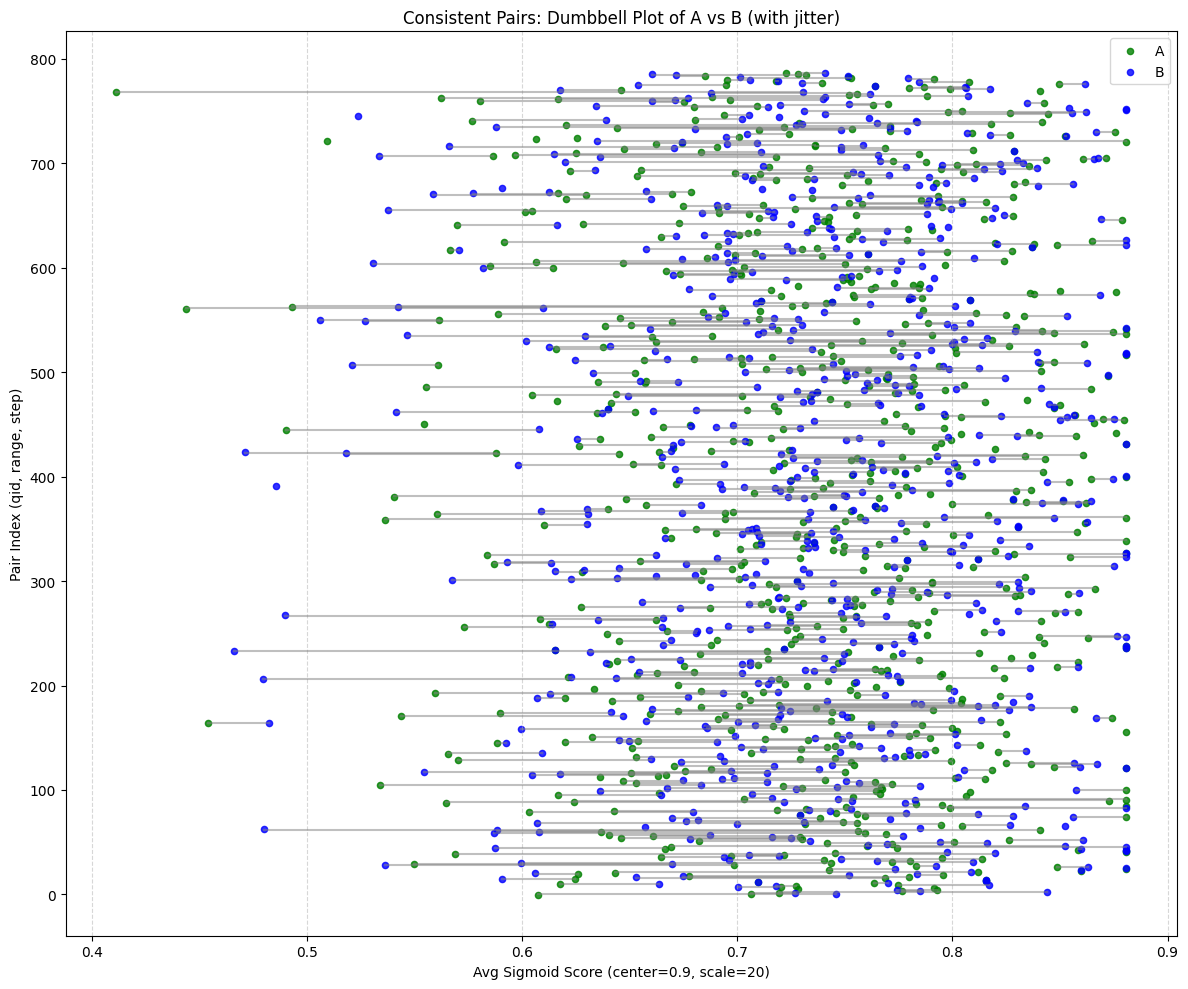

In [8]:

# ✅ 分组：计算每对 pair 的 A/B 平均 sigmoid 值
grouped = df_pos.groupby(['qid', 'range_tag', 'step']).apply(
    lambda x: pd.Series({
        'A_avg': x.loc[x['pair_role'] == 'A', 'avg_sigmoid_score_scaled'].mean(),
        'B_avg': x.loc[x['pair_role'] == 'B', 'avg_sigmoid_score_scaled'].mean()
    })
).reset_index()

# ✅ 绘制哑铃图
plt.figure(figsize=(12, 10))

# 抖动参数
jitter_strength = 0.2
y_indices = np.arange(len(grouped))
y_indices_A = y_indices - jitter_strength
y_indices_B = y_indices + jitter_strength

# 横线
for idx, row in grouped.iterrows():
    plt.plot([row['A_avg'], row['B_avg']], [y_indices[idx], y_indices[idx]], color='grey', alpha=0.5)

# A 和 B 的点
plt.scatter(grouped['A_avg'], y_indices_A, color='green', label='A', alpha=0.8, s=20)
plt.scatter(grouped['B_avg'], y_indices_B, color='blue', label='B', alpha=0.8, s=20)

# 细节设置
plt.xlabel("Avg Sigmoid Score (center=0.9, scale=20)")
plt.ylabel("Pair Index (qid, range, step)")
plt.title("Consistent Pairs: Dumbbell Plot of A vs B (with jitter)")
plt.legend(loc='upper right')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [9]:
# 统计 B 比 A 大、A 比 B 大的数量
b_greater_a = (grouped['B_avg'] > grouped['A_avg']).sum()
a_greater_b = (grouped['A_avg'] > grouped['B_avg']).sum()

print(f"✅ B_avg > A_avg 的数量: {b_greater_a}")
print(f"✅ A_avg > B_avg 的数量: {a_greater_b}")


✅ B_avg > A_avg 的数量: 319
✅ A_avg > B_avg 的数量: 310
